In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

sns.set_theme(palette="RdBu", style="darkgrid")

In [3]:
data_dir = "../../data/"

In [10]:
transcripts = pd.read_csv(data_dir + "earn_call_hw_transcripts.csv")

In [11]:
transcripts.dropna(subset=["P_clean", "QA_clean"], inplace=True)
transcripts.reset_index(drop=True, inplace=True)
# transcripts.duplicated(subset=["transcriptid"]).sum()

In [19]:
tid_idx = dict( zip(transcripts.transcriptid, transcripts.index) )

## 1.(a)

In [14]:
def buildDTM(doc_list):
    cv = CountVectorizer()
    dtm = cv.fit_transform(doc_list)
    return cv, dtm

cv_p, dtm_p = buildDTM(transcripts["P_clean"].tolist())
cv_qa, dtm_qa = buildDTM(transcripts["QA_clean"].tolist())

In [ ]:
# Now calculate the cosine similarity between an earnings call transcript and the previous year’s transcript for the same quarter.
meta = pd.read_csv(data_dir + "earn_call_meta_data.csv")

In [20]:
def getSimilarity(section):
    if section == "Presentation":
        dtm = dtm_p
    elif section == "Q&A":
        dtm = dtm_qa
    
    similarity = [] # cosine similarity

    for _, row in meta.iterrows():
        tid, tid_lag1yr = row["transcriptid"], row["transcriptid_lag1yr"]
        idx = tid_idx.get(tid) # get corresponding index (primary key) in transcrpits df
        idx_lag1yr = tid_idx.get(tid_lag1yr)

        if (idx is None) or (idx_lag1yr is None):
            similarity.append(None)
            continue

        arr = dtm[idx, :]
        arr_lag1yr = dtm[idx_lag1yr, :]

        similarity.append( cosine_similarity(arr, arr_lag1yr)[0, 0] )

    return similarity

meta["QA_sim"] = getSimilarity("Q&A")
meta["Pre_sim"] = getSimilarity("Presentation")

(i) Plot histograms for the presentation and Q&A similarity scores. What patterns do you notice? What differences are there between the two?

count    22701.000000
mean         0.960755
std          0.049718
min          0.029877
25%          0.954663
50%          0.972209
75%          0.983135
max          1.000000
Name: Pre_sim, dtype: float64


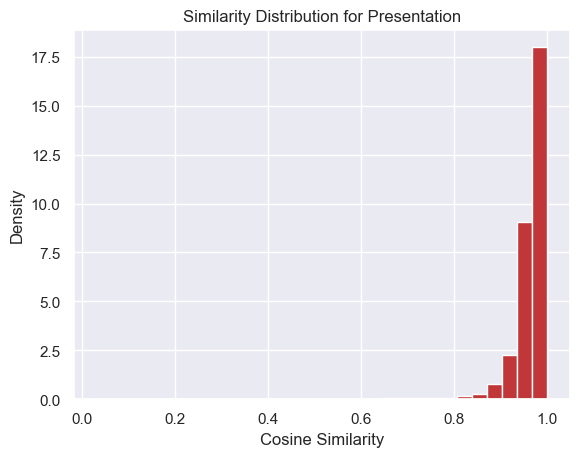

In [59]:
plt.figure()
plt.hist(meta.Pre_sim, bins=30, density=True)
plt.title("Similarity Distribution for Presentation")
plt.ylabel("Density")
plt.xlabel("Cosine Similarity")
plt.close

print(meta.Pre_sim.describe())

count    22701.000000
mean         0.867225
std          0.064329
min          0.059407
25%          0.834740
50%          0.877760
75%          0.912426
max          1.000000
Name: QA_sim, dtype: float64


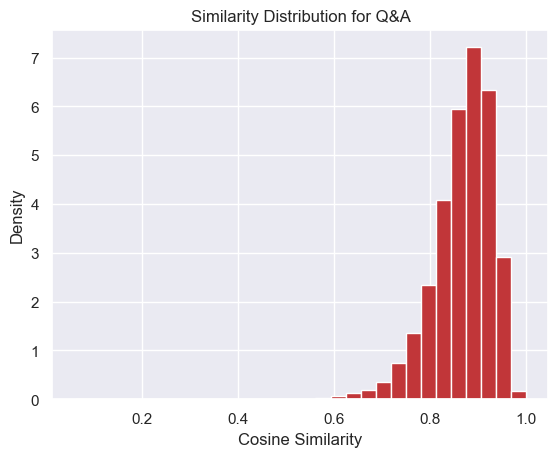

In [58]:
plt.figure()
plt.hist(meta.QA_sim, bins=30, density=True)
plt.title("Similarity Distribution for Q&A")
plt.ylabel("Density")
plt.xlabel("Cosine Similarity")
plt.close

print(meta.QA_sim.describe())

__Comment__:
* Similarity of presentation section has a  more centered distribution.
* Similarity is higher in presentation than in Q&A.

(ii) Plot the quarterly average similarity over time (one series for each section). Comment on any patterns in the time series.

In [38]:
meta["dt"] = pd.to_datetime(meta["date"])
meta["yyqq"] = meta["dt"].apply(lambda x: str(x.year) + 'Q' + str(x.quarter) ) #year-quater
meta.drop(["dt"],axis=1, inplace=True)

qtr_sim = pd.DataFrame( meta.groupby("yyqq")["Pre_sim", "QA_sim"].mean() ).reset_index()
qtr_sim["qtr"] = qtr_sim["yyqq"].apply(lambda x: x[-2:])
qtr_sim.set_index("yyqq", inplace=True)

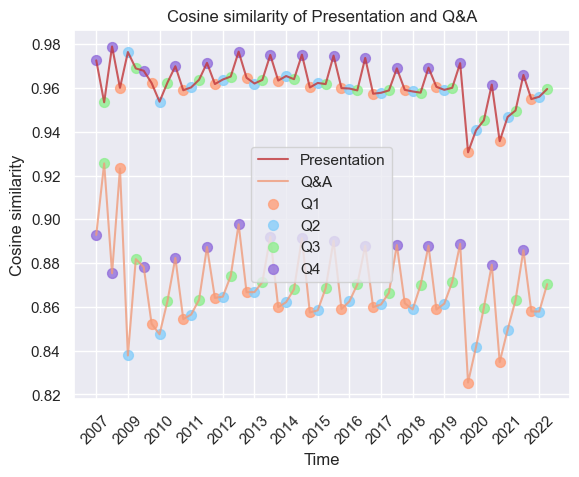

In [48]:
color_dict = {"Q1":"#FFA07A", "Q2": "#87CEFA", 
              "Q3": "#90EE90", "Q4": "#9370DB"}

fig, ax = plt.subplots()

ax.plot(qtr_sim.index, qtr_sim["Pre_sim"], linestyle='-', label="Presentation", alpha=0.8)
ax.plot(qtr_sim.index, qtr_sim["QA_sim"], linestyle='-', label="Q&A", alpha=0.8)

for qtr, color in color_dict.items():
    subset = qtr_sim[qtr_sim["qtr"] == qtr]
    ax.scatter(subset.index, subset["QA_sim"], marker='o', color=color, s=50, alpha=0.8)
    ax.scatter(subset.index,  subset["Pre_sim"], marker='o', color=color, label=qtr, s=50, alpha=0.8)

ax.set_xlabel("Time")
ax.set_ylabel("Cosine similarity")
ax.set_title("Cosine similarity of Presentation and Q&A")

xticks = qtr_sim.index[::4]
xticklabels = [label.split('Q')[0] for label in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45)

ax.legend()
plt.show()

In [62]:
print(qtr_sim.groupby("qtr").mean())

      Pre_sim    QA_sim
qtr                    
Q1   0.956378  0.859669
Q2   0.958739  0.856182
Q3   0.959552  0.872428
Q4   0.971530  0.887023


__Comment__


* We can see that overall, transcripts in Q3 and Q4 have higher similarity than in Q1 and Q2. Q4 earning calls are most similar over time.
* Similarity dropped in 2020.

(iii) Select two events in the bottom decile of similarity (i.e., most different) for the presentation section, excluding calls in 2020 and 2021. Qualitatively, what seems to explain the difference between the two calls? Are there any contemporaneous news reports that suggest a reason for the low similarity?

In [281]:
# how to merge?
df_all = pd.merge(transcripts, meta, how='left', on='transcriptid')

In [292]:
df = df_all.dropna(subset=["mostimportantdateutc", "Pre_sim", "QA_sim"])
df["yymmdd"] = pd.to_datetime(df.date)
df = df.query("(dt < 2020) | (dt > 2021)") # excluding calls in 2020 and 2021 

/var/folders/6q/bp8zcmjx7_d5s99yfjlq82540000gn/T/ipykernel_18617/3586310866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["yymmdd"] = pd.to_datetime(df.date)


In [283]:
bottom_tid, bottom_tid_lag1yr = df[df.Pre_sim == df["Pre_sim"].quantile(0.1)][["transcriptid", "transcriptid_lag1yr"]].values.flatten()

In [419]:
df[df.transcriptid == bottom_tid]

,transcriptid,P_clean,QA_clean,P_raw,QA_raw,companyid,date_cal,date,mostimportantdateutc_lag1yr,transcriptid_lag1yr,...,abn_retm_172,abn_retm_173,abn_retm_174,abn_retm_175,abn_retm_176,abn_retm_177,abn_retm_178,abn_retm_179,abn_retm_180,abn_retm_181
8307,814232,thank jami good morn welcom precis castpart ea...,yes mark hope could calibr us pace recoveri fo...,"Thank you, Jamie, good morning, and welcome to...","Yes. Mark, I was hoping you could calibrate us...",297850.0,2015-03-31,2015-05-13,2014-05-08,631019.0,...,-0.025693,0.013113,-0.00458,-0.002874,0.001827,-0.012308,-0.009359,0.002561,0.013983,-0.002249


In [421]:
df[df.transcriptid == bottom_tid_lag1yr]

,transcriptid,P_clean,QA_clean,P_raw,QA_raw,companyid,date_cal,date,mostimportantdateutc_lag1yr,transcriptid_lag1yr,...,abn_retm_172,abn_retm_173,abn_retm_174,abn_retm_175,abn_retm_176,abn_retm_177,abn_retm_178,abn_retm_179,abn_retm_180,abn_retm_181
6422,631019,thank oper sure veri familiar forward look sta...,guess _num_ question one could first elabor ...,"Thank you, operator. I'm sure by now you're al...","I guess, 2 questions. One, if you could just f...",297850.0,2014-03-31,2014-05-08,2013-05-09,586209.0,...,-0.000547,-0.005852,0.003199,0.005478,0.004477,0.00054,-0.003359,-0.001113,0.010753,-0.007484


In [244]:
print(df[df.transcriptid == bottom_tid].iloc[0].P_raw)

Thank you, Jamie, good morning, and welcome to Precision Castparts' Earnings Conference Call for the Fourth Quarter of Fiscal Year 2015. Here with me today are Chairman and CEO, Mark Donegan; and Executive Vice President and CFO, Shawn Hagel. 
Portions of today's presentation contain forward-looking statements that are based on our current view of the future commercial environment and our businesses. The factors that determine those outcomes can change, and we ask that you interpret any forward-looking statements in that light. We identified the principal risks and uncertainties that affect our performance on Page 2 of today's presentation and in our Form 10-K and other SEC filings. 
In today's presentation, the company will refer to certain non-GAAP financial measures. A reconciliation of these non-GAAP financial measures is available in the appendix of the presentation slides, which have been posted to our website at www.precast.com/investors/presentations.
We will be making some enh

In [240]:
print(df[df.transcriptid == bottom_tid_lag1yr].iloc[0].P_raw)

Thank you, operator. I'm sure by now you're all very familiar with our forward-looking statement and you need to take into consideration when analyzing the following presentation. 
If I look at Q4, I think it reflected our unyielding adherence to our core principles. At the center of those principles is always going to be our unrelenting attack on our operating cost. We want every minute of every day people focused on capturing the endless opportunities in front of us. We're going to utilize our technology, our vertical integration, cross-utilization of assets to make sure we maximize that value. We're going to continue to systematically identify the right acquisitions -- not any acquisition, the right ones for us. Once we acquire, we're going to rapidly drive our integration process. We're going to deliver substantially improved performance on our end markets. And we're always going to do it in an environment that each plant feels as though they are the whole company. We want them to 

The difference may result from unfavorable mix of oil and gas-related sales in the quarter and the impact from the inability to move inventory due to lower oil price and distributor demand. Adjusted consolidated segment operating income decreased 13% to $624 million.

### (b)
Now use your similarity scores to run an event study analyzing the impact of high versus low similarity. Using only the presentation section, obtain the top and bottom deciles of similarity over the whole sample. However, exclude calls in 2020 and 2021 in obtaining the deciles.

Now define the low similarity events as those with presentation similarity scores in the bottom decile and high similarity events as those with score in the top decile. Again, exclude 2020 and 2021 in selecting the events.
To match the sentiment scores with returns, you can use the mapping file earn_call_meta_data.csv and daily_rets_hw3.csv. Both include a companyid column that matches the transcripts to the company/stock.


In [285]:
rets = pd.read_csv(data_dir + "daily_rets_hw3.csv")
factors = pd.read_csv(data_dir + "factors.csv")

# Abnormal return pivot table
ret_ff = pd.merge(rets, factors, on="date", how="inner")
ret_ff["abn_ret"] = ret_ff["ret"] - ret_ff["sprtrn"] # abnormal return
abn_ret_table = ret_ff.pivot(index="date", columns="companyid", values="abn_ret")

In [296]:
# Rename date columns to aviod confussion
df.rename(columns={"date": "date_cal"}, inplace=True)
df.rename(columns={"mostimportantdateutc":"date"}, inplace=True)

In [310]:
abn_10d_cols = []

for window in tqdm( range(1,22) ):
    col_name = "abn_ret" + str(window)
    abn_10d_cols.append(col_name)

    abn_ret_dayi = abn_ret_table.shift(11-window).stack().rename(col_name).reset_index()
    df = df.merge(abn_ret_dayi,on=["companyid","date"], how="left")

100%|██████████| 21/21 [00:10<00:00,  1.97it/s]


In [312]:
abn_3m_cols = []

for window in tqdm(range(1, 182)):
    col_name = 'abn_retm_'+str(window)
    abn_3m_cols.append(col_name)

    abn_ret_dayi = abn_ret_table.shift(91-window).stack().rename(col_name).reset_index()
    df = df.merge(abn_ret_dayi, on = ['companyid','date'], how = 'left')

100%|██████████| 181/181 [01:28<00:00,  2.04it/s]


(i) Plot the cumulative abnormal returns of the high and low similarity portfolios for trading days t−10 to t+10.


(ii) Plot the cumulative abnormal returns of the high and low similarity portfolios for months m−3 to m+3.

In [415]:
def CAR(section):
    
    if section == "Presentation":
        target = "Pre_sim"
    elif section == "Q&A":
        target = "QA_sim"
    
    q10 = df[target].quantile(0.1)
    q90 = df[target].quantile(0.9)

    lowSim_df = df[df[target] <= q10]
    highSim_df = df[df[target] >= q90]


    # +- 10 DAYS
    # Average returns
    highSim_ret = highSim_df[abn_10d_cols].mean(axis=0)
    lowSim_ret = lowSim_df[abn_10d_cols].mean(axis=0)
    # CAR
    highSim_CAR = (1 + highSim_ret).cumprod() - 1
    lowSim_CAR = (1 + lowSim_ret).cumprod() - 1

    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(highSim_CAR, label="High Similarity")
    ax.plot(lowSim_CAR, label="Low Similarity")
    xticklabels = ['T' + str(i - 10) for i in range(10)] + ['T+' + str(i) for i in range(11)]
    ax.set_xticklabels(xticklabels)
    ax.legend()
    plt.title(f"CAR for High&Low {section} Similarity Portfolios (t-10 to t+10)")


    # +- 3 MONTHS
    # Average returns
    highSim_ret = highSim_df[abn_3m_cols].mean(axis=0)
    lowSim_ret = lowSim_df[abn_3m_cols].mean(axis=0)
    # CAR
    highSim_CAR = (1 + highSim_ret).cumprod() - 1
    lowSim_CAR = (1 + lowSim_ret).cumprod() - 1

    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(highSim_CAR, label="High Similarity")
    ax.plot(lowSim_CAR, label="Low Similarity")
    xticks = highSim_CAR.index[::30]
    xticklabels = ['T' + str(x) for x in np.arange(-90,90+30,30)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.legend()
    plt.title(f"CAR for High&Low {section} Similarity Portfolios (m-3 to m+3)")

(ii) Plot the cumulative abnormal returns of the high and low similarity portfolios for months m−3 to m+3.

/var/folders/6q/bp8zcmjx7_d5s99yfjlq82540000gn/T/ipykernel_18617/1397377749.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


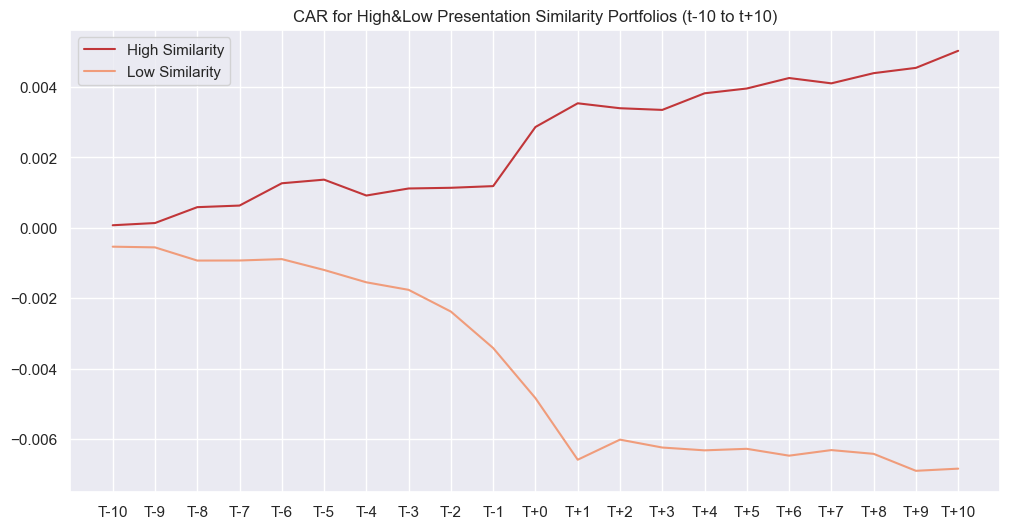

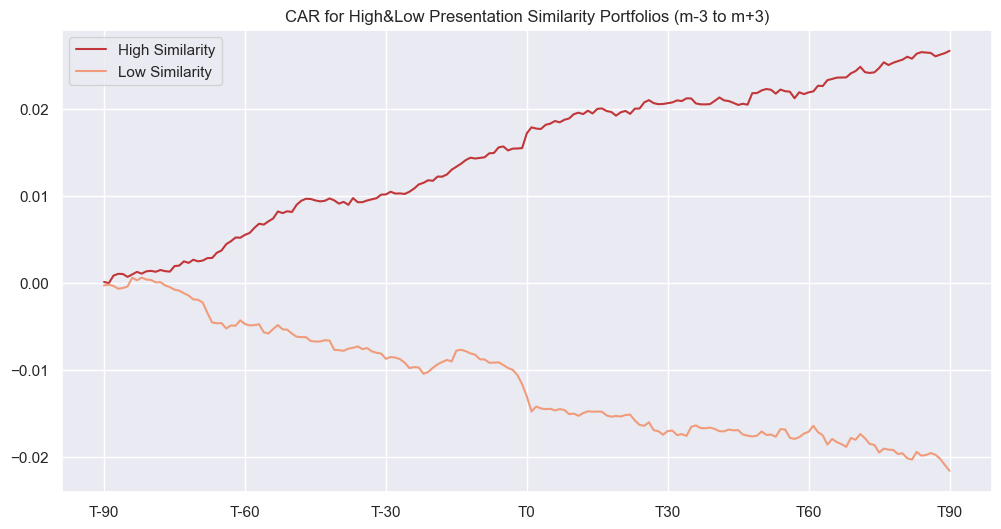

In [416]:
CAR(section="Presentation")

(iii) Comment on the any differences between the shorter and longer horizon effects and potential explanations.

* High and low similarity portfolios exhibit distinct behavior. In the shorter horizon, the CAR in the low similarity portfolio drops starting 10 days before the event day, but the decline appears to be more flat after the earnings call.
* In the longer horizon, the performances of the high and low similarity portfolios seem quite "symmetric". This difference may suggest that investors favor markets with consistent performance, as they view consistent performance as a sign of stability and reliability.

(iv) Repeat the above analysis using the Q&A section

/var/folders/6q/bp8zcmjx7_d5s99yfjlq82540000gn/T/ipykernel_18617/1397377749.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


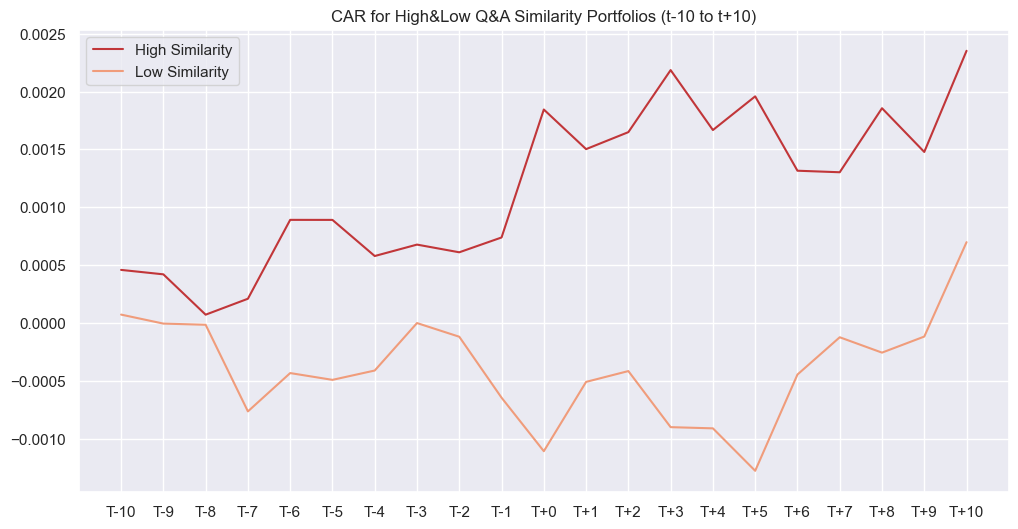

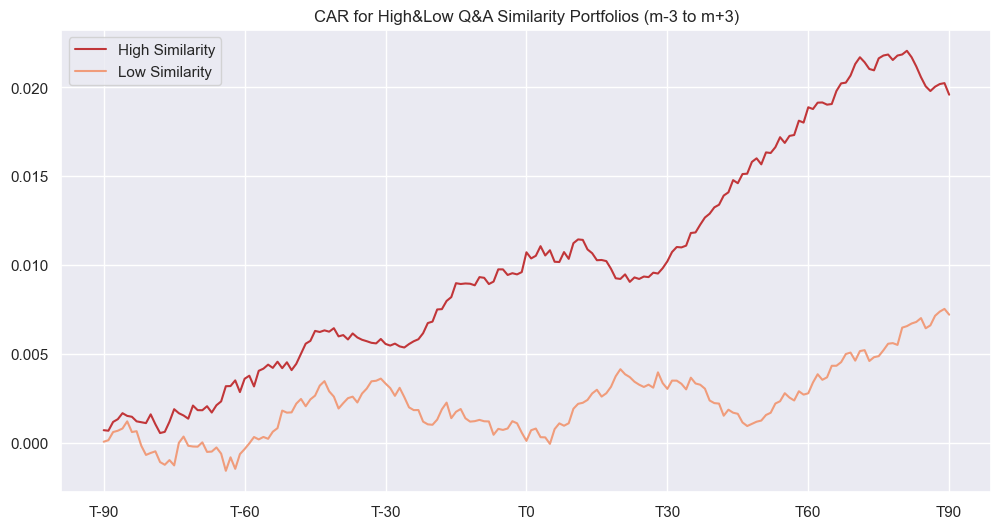

In [417]:
CAR(section="Q&A")

__Comment on the any differences between the shorter and longer horizon effects and potential explanations.__

* Both high and low similarity portfolios exhibit an upward trend in returns from 3 months before the event day to 3 months after. However, the high-similarity portfolio outperforms the low-similarity portfolio. Returns experience greater fluctuations around the event day (±10 days), with a noticeable rise in the high-similarity portfolio and a drop in the low-similarity portfolio on the event day. Predicting returns based on Q&A similarity remains challenging.

* These findings also highlight significant differences between presentation and Q&A sections. A low similarity in the Q&A section may indicate that a company is facing big changes in its business, leading to varying investor sentiment

# Question 2: Neural Networks and Image Classification

In [187]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, losses


(a) Using Keras/TensorFlow, design a network that uses ≤ 100,000 parameters (you can see the number of parameters by running model.summary()).

(b) Train the model on the training data set of 60,000 images.

(c) Now evaluate the model on the 10,000 hold-out testing set of images (make sure you do not train the model using the test images!).

In [181]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.mnist.load_data()
# train: 60,000
# test: 10,000

In [185]:
ytrainp = tf.keras.utils.to_categorical(ytrain)
ytest = tf.keras.utils.to_categorical(ytest)

In [186]:
# For NN
# xtrainp = tf.cast(np.reshape(xtrain/255., [-1,784]), tf.float32)
# xtestp = tf.cast(np.reshape(xtest/255., [-1,784]), tf.float32)

In [401]:
xtrainp = np.reshape(xtrain, (60000, 28, 28, 1))
xtrainp = xtrainp.astype(float) / 255

xtestp = np.reshape(xtest, (10000, 28, 28, 1))
xtest = xtest.astype(float) / 255

In [407]:
def buildCNN(f1, f2, f3):

    model = Sequential()
    model.add( layers.Conv2D(filters=f1, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)) )
    model.add( layers.MaxPool2D(pool_size=(2, 2), strides=None) )

    model.add( layers.Conv2D(filters=f2, kernel_size=(3,3), activation='relu') )
    model.add( layers.MaxPool2D(pool_size=(2, 2), strides=None) )
    
    model.add( layers.Flatten() )
    model.add( layers.Dense(f3, activation='relu') )
    model.add( layers.Dropout(0.1) )

    model.add( layers.Dense(10, activation='softmax')) 

    model.compile(optimizer = "rmsprop", loss='categorical_crossentropy', metrics='accuracy')
    
    print(model.summary())

    return model

(c) Now evaluate the model on the 10,000 hold-out testing set of images (make sure you do not train the model using the test images!).

In [414]:
model = buildCNN(6, 12, 24)
res = model.fit(xtrainp, ytrainp,
          epochs=10,
          batch_size=60,
          verbose=0,
          validation_split=0.1)
print("Test set accuracy: ", model.evaluate(xtestp, ytest, verbose=0)[1])

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 26, 26, 6)         60        
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 13, 13, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 11, 11, 12)        660       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 5, 5, 12)         0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 300)               0         
                                                                 
 dense_86 (Dense)            (None, 24)              

In [413]:
print("Test set accuracy: ", model.evaluate(xtestp, ytest, verbose=0)[1])

Test set accuracy:  0.9550999999046326


(d) Evalute the model’s accuracy (the percent of the 10,000 images that are correctly classified).


(e) Comment on why your model works well or poorly.

* I follow the work in Chollet's Deep Learning for this classfication, but restricted the number of paramters < 100,000. 
* The CNN model outperforms the model we use in class, with an accuracy over 95%. CNNs can identify local patterns such as edges, corners, and curves by applying convolutional filters. This is helpful when capturing the unique shapes of each digit and distinguish different digits images